### Putting everything together, plot details of the large M7.8 Earthquake

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

#-- To import a function on a relative path:
import sys
sys.path.append("./")
from pydas_readers.readers import load_das_h5
from pydas_readers.util import block_filters
from pydas_readers.mapping import channel_mapping


#-- Optional to make the map
from ipyleaflet import Map, basemaps, basemap_to_tiles, Polyline, Marker


#### Load Data

In [2]:
#-- Data here is in "example_data_Istanbul"
input_dir = "example_data_Istanbul"

#-- Get channel mapping details
mapping = channel_mapping.get_mapping(data_type="clean", d_start=0, d_end=8000)

#-- Specify time of the earthquake
#-- 2023-02-06 01:17:34 (UTC)
t_start = datetime.strptime('2023/02/06 01:17:34.0', '%Y/%m/%d %H:%M:%S.%f') 
t_end   = datetime.strptime('2023/02/06 01:27:34.0', '%Y/%m/%d %H:%M:%S.%f') 

#-- Specifically, argument ichan=[] to specify which channels should be loaded.
data, headers, axis = load_das_h5.load_das_custom(t_start, t_end, ichan=mapping['ii'], input_dir=input_dir, verbose=False, convert=True) #
print("Data [npts x nchan]: {0}".format(np.shape(data)))

Data [npts x nchan]: (120001, 710)


#### Basic Filtering

In [3]:
#-- Bandpass Filter (and taper)
f1 = 0.1
f2 = 15.0
data_filtered = block_filters.block_bandpass(data, f1, f2, headers['fs'], zerophase=False, taper=0.02)
print("   Filtering completed")

   Filtering completed


#### Plotting

In [4]:
plt.rcParams.update({'font.size': 14})

#-- Define a function for making the waterfall plot:
def waterfall(data,headers,mapping,ax,vlim=0):

    #-- imshow data
    if(vlim==0):
        vlim = np.mean(np.abs(data))*10
    im = ax.imshow(data.T, aspect="auto", cmap='seismic', interpolation='antialiased', 
            extent=(0,headers["npts"]/headers["fs"], mapping["dd"][-1]/1000,mapping["dd"][0]/1000),
            vmin=-vlim, vmax=vlim)
    
    #-- y-axis
    ax.set_ylabel("Distance Along Fiber [km]")

    #-- Define the x-tick marks we want, format the labels
    x_timestamp_interval = 120 # seconds
    x_positions = np.arange(0, headers["npts"]/headers["fs"], x_timestamp_interval)  # time-samples
    x_labels_times = [None]*len(x_positions)
    for i,t in enumerate(x_positions):
        x_labels_times[i] = (headers['t0'] + timedelta(seconds=t)).strftime('%H:%M:%S')
    ax.set_xticks(x_positions, x_labels_times)
    ax.set_xlabel("Time (UTC)")

    if(headers['unit']=="(nm/m)/s"):
        #-- Because we used the flag, "convert=True" when reading, the units are physical.
        plt.colorbar(im,label="Strain-Rate [(nm/m)/s]",ax=ax)
    else:
        plt.colorbar(im,label="Optical Intensity",ax=ax)
 

    ax.set_title('M7.8 Earthquake: Kahramanmaraş, Turkey'.format(headers['t0'].strftime('%Y.%m.%d')))
    ax.invert_yaxis()
    return ax



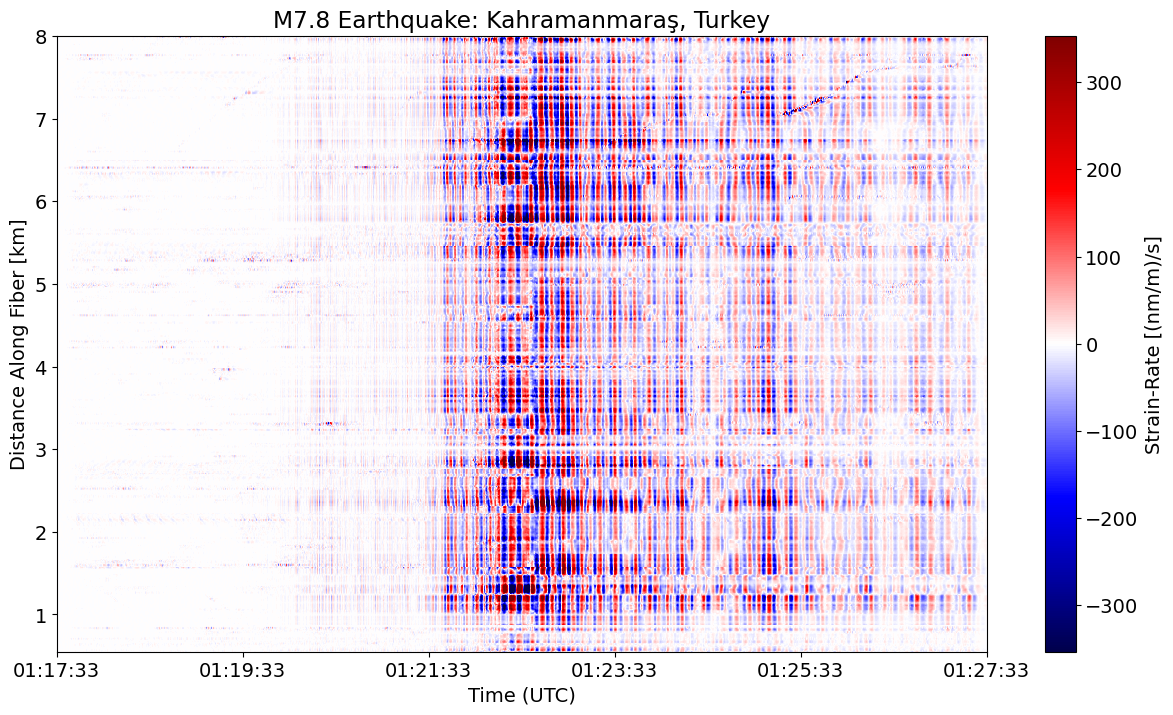

In [30]:
fig,ax = plt.subplots(figsize=(15,8))
ax = waterfall(data_filtered,headers,mapping,ax)

#### Map of the channel locations

In [82]:
#-- Plot a map of the fiber locations
m = Map(
    # basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik),
    # basemap=basemap_to_tiles(basemaps.Esri.WorldStreetMap),
    basemap=basemap_to_tiles(basemaps.Esri.WorldImagery),

    center=( 40.95, 29.073),
    zoom=12
    )
 
#-- Get the lat/lon into the right format
locs = np.column_stack((mapping['lat'],mapping['lon']))

line = Polyline(
    locations=[locs],
    color="magenta" ,
    fill=False
)

m.add_layer(line)

marker = Marker(location=[locs[0,0],locs[0,1]], draggable=False)
m.add_layer(marker)
# marker = Marker(location=[locs[1,1],locs[1,0] ], draggable=False)
# m.add_layer(marker);

m

Map(center=[40.95, 29.073], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…